# Data generation code based on the KV equations

The data generation involved solving the KV equations across varied initial conditions and quadrupole focusing parameters, randomly sampled to reflect realistic particle accelerator operations. The solver produced time-series data for $r_x(s)$, $r_x'(s)$, $r_y(s)$, and $r_y'(s)$, capturing transverse beam dynamics as a function of longitudinal position $s$. Each sample was saved in structured files for easy analysis. Simulation parameters were drawn from \cite{car}, with the focusing strength $k(s)$ based on a periodic quadrupole structure.

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os

# Create the folder 'data' if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Constants
num_samples_train = 600  # Number of training samples
num_samples_test = 22    # Number of testing samples
num_quadrupoles = 22         # Number of quadrupoles
step_size = 0.0588           # Step size in meters
s_max = 24.9                 # Maximum s value
n_steps = int(s_max / step_size)  # Number of steps for integration

# Function to define the KV equations
def kv_equations(s, y, focusing= 'quad'):
    X, X_prime, Y, Y_prime = y
    epsilon_x = 0.01 # Emittance in x [mm-mrad] 
    epsilon_y = 0.01 # Emittance in y [mm-mrad]
    Q = .1 # Space charge tune depression

    kx = generate_focusing_params(s) # Focusing strength in x [Tesla/meter]
    if focusing == 'quad':
        ky = -kx # Quadrupole strength in y [Tesla/meter]
    else:
        ky = kx # Solenoid strength in y [Tesla/meter]
   
    dXds = X_prime
    dYds = Y_prime

    dX_primes = (epsilon_x**2 / X**3) + 2*Q * (1 / (X + Y)) - kx *X
    dY_primes = (epsilon_y**2 / Y**3) + 2*Q * (1 / (X + Y)) - ky *Y  
    return [dXds, dX_primes, dYds, dY_primes]

def periodic_solenoid(s, Lp=3, eta=.5, kappa=1):
    """
    Generate a periodic solenoid-like signal.
    
    Parameters:
    - s: Position where the function is evaluated.
    - Lp: The total length of one period of the signal.
    - eta: Proportion of the period during which the signal is high.
    - kappa: The value of the signal when it's high.
    
    Returns:
    - signal: The solenoid signal.
    """
    d = (1 - eta) * Lp  # The length of the low signal (zero)
      
    # Define the high (kappa) region within each period
    pos_in_period = s % Lp
    # If position is in the high region (eta * Lp)
    if d / 2 <= pos_in_period < (d / 2 + eta * Lp):
            signal = kappa
    else:
        signal = 0
    
    return signal

def periodic_quadrupole_doublet(s, Lp=3, eta=.5, kappa=1, alpha=.15):
    """
    Parameters:
    - s: Position or array of positions where the function is evaluated.
    - Lp: The lattice period.
    - eta: Proportion of the period where the quadrupole fields are active.
    - kappa: The field strength of the quadrupole.
    - alpha: Proportion that defines d1 and d2 within the period.
    Returns:
    - signal: The periodic quadrupole doublet signal.
    """
    d1 = alpha * (1 - eta) * Lp  # Length of F Quadrupole region
        
    # Find position within the current period
    pos_in_period = s % Lp
        
    # Define regions for F Quad, D Quad, and zero field
    if pos_in_period < eta * Lp / 2:  # F Quad region (positive kappa)
        signal = kappa
    elif eta * Lp / 2 <= pos_in_period < d1 + eta * Lp / 2:  # Zero field region
        signal = 0
    elif d1 + eta * Lp / 2 <= pos_in_period < d1 + eta * Lp:  # D Quad region (negative kappa)
        signal = -kappa
    else:  # Zero field region again
        signal = 0
    
    return signal

# Function to generate random quadrupole configurations
def generate_focusing_params(s,focusing='quad'):
    # np.random.seed(42)
    if focusing == 'quad':
        signal = periodic_quadrupole_doublet(s)
    else:
        signal = periodic_solenoid(s)
    
    dn_solenoid = 0.05 * np.abs(signal)
    return np.random.uniform(signal - dn_solenoid, signal + dn_solenoid)

# Function to generate initial conditions
def generate_initial_conditions():
    X0 = np.random.uniform(0.5, 0.35) # Initial X position
    Y0 = np.random.uniform(0.5, 0.35) # Initial Y position
    X_prime_0 = np.random.uniform(0, 0.25) # Initial X angle
    Y_prime_0 = np.random.uniform(0, 0.25) # Initial Y angle
    return [X0, X_prime_0, Y0, Y_prime_0]

# Function to solve the KV equations and save each sample's data to a file
def generate_and_save_dataset(num_samples, s_max=11.7, n_steps=200):
    for i in range(1, num_samples + 1):
        data = []
        initial_conditions = generate_initial_conditions()
        # Solve the KV equations using the given initial conditions
        sol = solve_ivp(kv_equations, [0, s_max], initial_conditions, 
                        t_eval=np.linspace(0, s_max, n_steps))
        # Collect the results for each sample
        for s, X, X_prime, Y, Y_prime in zip(sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3]):
            data.append({
                's': s,
                'quadrupole_param_1': generate_focusing_params(s),
                'quadrupole_param_2': -generate_focusing_params(s),
                'X': X,
                'X_prime': X_prime,
                'Y': Y,
                'Y_prime': Y_prime })
        # Convert the data to a pandas DataFrame
        df = pd.DataFrame(data)
        # Save each sample's data to a separate CSV file
        file_name = f'data/sample_{i}.csv'
        df.to_csv(file_name, index=False)

## Plot this solution of the KV equations

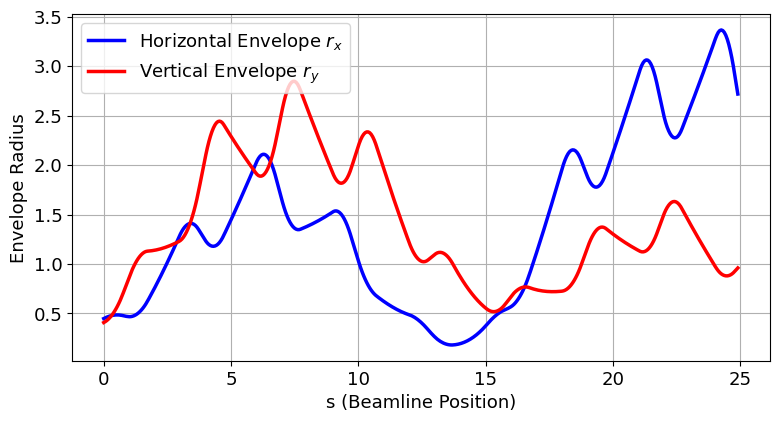

In [2]:
# focusing_params = generate_focusing_paramsperiodic_solenoid()
# print(focusing_params)
plt.rcParams.update({'font.size': 13})
initial_conditions = generate_initial_conditions()
solution = solve_ivp(kv_equations, [0, s_max], initial_conditions,t_eval=np.linspace(0, s_max, n_steps))

# Extract the solution
x_sol = solution.y[0]
y_sol = solution.y[2]

# Plot the results
plt.figure(figsize=(9, 4.5))
plt.plot(solution.t, x_sol, lw=2.5, label="Horizontal Envelope $r_x$", color='b')
plt.plot(solution.t, y_sol, lw=2.5, label="Vertical Envelope $r_y$", color='r')
plt.xlabel('s (Beamline Position)')
plt.ylabel('Envelope Radius')
# plt.title('Solution of KV Envelope Equations')
plt.legend()
plt.grid(True)
plt.savefig('KV_envelope_solution.png')
plt.show()

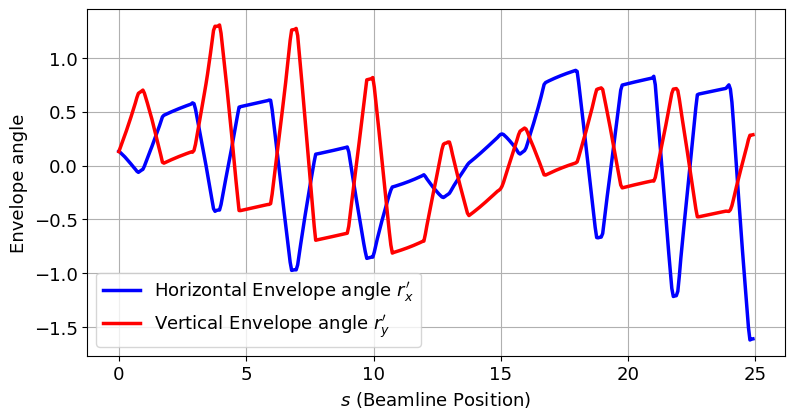

In [3]:
# Extract the solution
x_prime_sol = solution.y[1]
y_prime_sol = solution.y[3]

# Plot the results
plt.figure(figsize=(9, 4.5))
plt.plot(solution.t, x_prime_sol,lw=2.5, label="Horizontal Envelope angle $r_x'$", color='b')
plt.plot(solution.t, y_prime_sol,lw=2.5, label="Vertical Envelope angle $r_y'$", color='r')
plt.xlabel('$s$ (Beamline Position)')
plt.ylabel('Envelope angle')
# plt.title('Solution of KV Envelope Equations')
plt.legend()
plt.grid(True)
plt.savefig('KV_envelope_solution_angle.png')
plt.show()

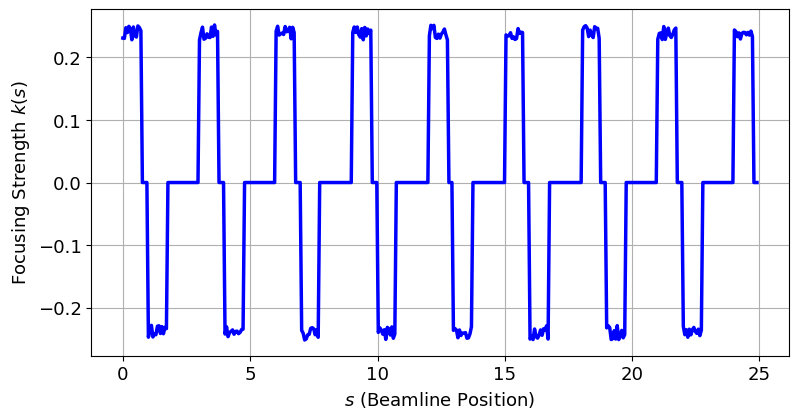

In [4]:
s = np.linspace(0, s_max, n_steps)  # Position values from 0 to 50 meters
Lp = 0.5  # Total period length
eta = 0.5  # High signal occupies 60% of the period
kappa = 1  # High signal value (e.g., 1 Tesla/meter)
lii = []
# Generate the periodic solenoid signal
for i in s:
    lii.append(generate_focusing_params(i)*0.24)    

# Plot the results
plt.figure(figsize=(9, 4.5))
plt.plot(s, lii, lw=2.5,label="Horizontal Envelope $r_x$", color='b')
plt.xlabel('$s$ (Beamline Position)')
plt.ylabel('Focusing Strength $k(s)$')
# plt.legend()
plt.grid(True)
plt.savefig('quad_signal.png')
plt.show()
